# Simulate data

This project uses the CMU_ARCTIC database, which is a speech database in CMU_ARCTIC speech synthesis databases, established by the Language Technologies Institute of Carnegie Mellon University, USA. This database is mainly used in the research of speech synthesis. The content of the corpus database was selected by the non-copyright center of Project Gutenberg, which is about 1150 sentences. An audio of two males and two females with American English accents were collected. The recording format is 16 bits, the sampling rate is 32 KHz, and the length of each sentence is 3 seconds. The database has a total of 4528 audio files.

## Imports

In [9]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize

## Constants

In [17]:
# Label resolution of angles
RESOLUTION = 20

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 2]),
    'medium' : np.array([6, 6, 2]),
    'large' : np.array([8, 8, 2])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data'

# Number of microphones
MICS_NUMBER = 4

## Definition for rooms, microphones and sources

In [18]:
def create_simulation_room(room_dim=[4, 4, 2], mic_pos=[2, 2, 1], room_fs=16000, noise=0):    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs, max_order=3, ray_tracing=True, sigma2_awgn=noise)
    w = room_dim[0]
    l = room_dim[1]
    h = room_dim[2]

    # Radius constant
    mic_radius = 0.045

    # Generate the microphone array
    mic_array_2D = pra.circular_2D_array(center=[w/2, l/2], M=MICS_NUMBER, phi0=0, radius=mic_radius)
    mic_array_3D = np.concatenate((mic_array_2D, np.ones((1, MICS_NUMBER)) * h/2), axis=0)

    # Generate the microphones
    #mic_loc = np.c_[[w/2+0.2, l/2, 0],[w/2-0.2, l/2, 0]] 
    #room.add_microphone_array(mic_loc)

    room.add_microphone_array(mic_array_3D)
    
    return room


def create_sound_sources(room_dim=[4, 4, 2], resolution=RESOLUTION):        
    # Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = [1., 2.]
    height_range = [room_dim[-1]/2]
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            for h in height_range:
                source = [R * math.cos(math.radians(angle)) + room_dim[0] / 2, 
                            R * math.sin(math.radians(angle)) + room_dim[0] / 2, h]
                sources[angle].append((R, h, source))
    return sources


def simulate_room(audio_file, subset, room_type='small', mic_pos=[2, 2, 0], label_res=20):
    file_name = os.path.basename(audio_file).split('.')[0]

    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]

    # Create all sound sources
    sources = create_sound_sources(room_dim)

    # Generate noise
    snr_db = 25.                                                    # signal-to-noise ratio
    noise = 10**(-snr_db / 10) / (4. * np.pi * 1.)**2               # noise variance set at 1m

    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'\nSimulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs, noise=noise)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate()

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 2 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_{file_name}.wav'
            wavfile.write(f'{AUDIO_PATH}/{save_name}', 16000, np.array(wav_signals[dist]))
        
        if angle % label_res == label_res - 1:
            print(' Done.')
            
    print('\nSimulation successful!')

## Run simulations

In [19]:
print('Simulating training data:')

for room, dim in ROOMS.items():
    # Call the function above and store all results
    print(f'Room: {room}')
    sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0014.wav"
    simulate_room(sound_files, 'train', room, dim / 2, label_res=60)


print('Simulating test data:')
for room, dim in ROOMS.items():
    # Call the function above and store all results
    print(f'Room: {room}')
    sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0015.wav"
    simulate_room(sound_files, 'test', room, dim / 2, label_res=60)


Simulating training data:
Room: small

Simulating 0-59 degrees: ###
Simulating 60-119 degrees: ###
Simulating 120-179 degrees: ###
Simulating 180-239 degrees: ###
Simulating 240-299 degrees: ###
Simulating 300-359 degrees: ###
Simulation successful!
Room: medium

Simulating 0-59 degrees: ###
Simulating 60-119 degrees: ###
Simulating 120-179 degrees: ###
Simulating 180-239 degrees: ###
Simulating 240-299 degrees: ###
Simulating 300-359 degrees: ###
Simulation successful!
Room: large

Simulating 0-59 degrees: ###
Simulating 60-119 degrees: ###
Simulating 120-179 degrees: ###
Simulating 180-239 degrees: ###
Simulating 240-299 degrees: ###
Simulating 300-359 degrees: ###
Simulation successful!
Simulating test data:
Room: small

Simulating 0-59 degrees: ###
Simulating 60-119 degrees: ###
Simulating 120-179 degrees: ###
Simulating 180-239 degrees: ###
Simulating 240-299 degrees: ###
Simulating 300-359 degrees: ###
Simulation successful!
Room: medium

Simulating 0-59 degrees: ###
Simulating 6

## Check output

In [ ]:
fs, audio = wavfile.read(f'{AUDIO_PATH}/train_angle_0_dist_100_room_large_.wav')
cols = [f'mic_{i}' for i in range(2)]
df = pd.DataFrame(data=audio, columns=cols, dtype=np.int16)
df.iloc[2000:2005]

,mic_0,mic_1
2000,2531,-1892
2001,8575,-2287
2002,-19110,-2925
2003,13009,4793
2004,9942,9297


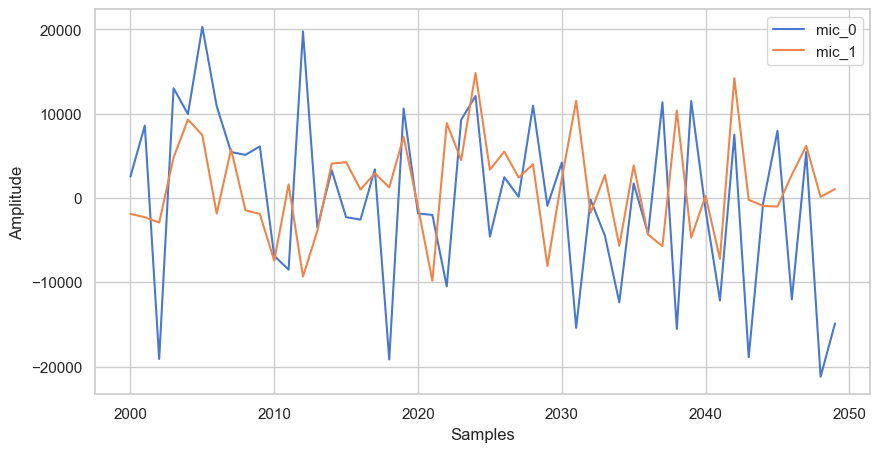

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
df.iloc[2000:2050].plot(ax=ax)
plt.show()

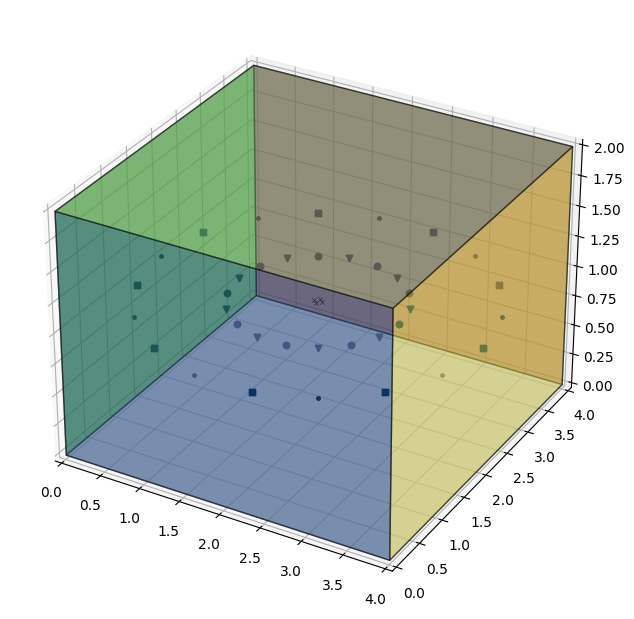

In [6]:
room_dim = ROOMS['small']

room = create_simulation_room(room_dim, mic_pos=room_dim / 2)
sources = create_sound_sources(room_dim)

def plot_room(room, sources, signal):
    # Add every single source to the room
    for angle, sources in sources.items():
        for _, _, source in sources:
            room.add_source(source, signal=signal, delay=0.5)

    # Plot the room
    fig, ax = room.plot()
    fig.set_size_inches(6, 6)
    ax.set_xlim([0, room_dim[0]])
    ax.set_ylim([0, room_dim[1]])
    ax.set_zlim([0, room_dim[2]])
    
plot_room(room, sources, sound_files)